In [3]:
from tensorflow.keras.models import load_model
import util1 as u

model_file = '模型_DNN.h5' # 要載入的已訓練模型檔
imgs_name = ('MNIST','鉛筆',     '藍筆',        '滑鼠'     ) # 要載入的圖檔種類, 第0個固定為MNIST
imgs_dir =  ('MNIST','pic_2BPen','pic_BluePen','pic_Mouse') # 要載入的圖檔資料夾, 第0個已固定勿改

sets = (0,1,2,3)  # 要測試哪些資料集 (0:MNIST, 1:鉛筆, 2:藍筆, 3:滑鼠)
show = 10         # 要顯示多少張圖, 0 為不顯示
labs = (1,)       # 要進行哪些實驗, 可指定 1 或多個, 例如 (1,) 或 (3,4,5)



載入模型及參數...
載入圖檔及標籤...
模型評估 10000 張【MNIST】圖片的準確率：98.0%


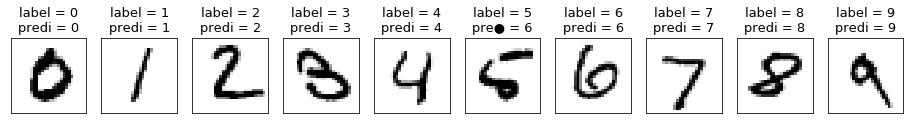

模型評估 200 張【鉛筆】圖片的準確率：83.5%


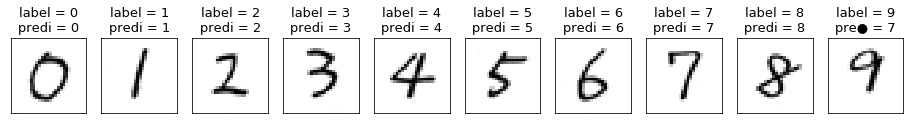

模型評估 200 張【藍筆】圖片的準確率：36.0%


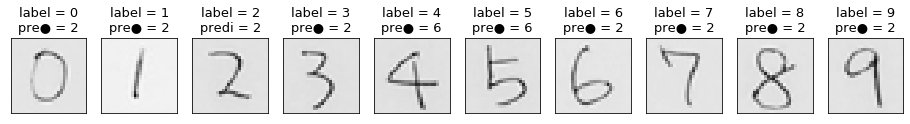

模型評估 200 張【滑鼠】圖片的準確率：50.0%


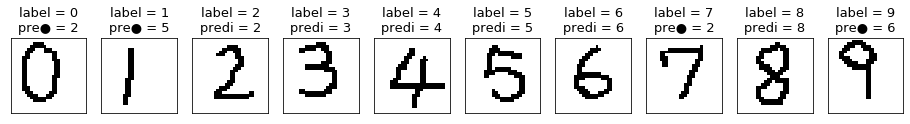

In [4]:
# 評估指定的圖片資料集
# func:評估前要先呼叫的圖片處理函式
# kwargs:要傳遞給 func 的指名參數 (可有 0 到多個)
def eval_all(func=None, **kwargs):
    for i in sets:   # 走訪每一個指定要測試的資料集
        imgs = []
        for img in imgsets[i]: # 走訪目前資料集中的影像
            img = img.copy()   # 複製一份, 以免改變到原始資料
            if func: img = func(img, **kwargs) # 呼叫指定的影像處理函式
            imgs.append(img)   # 加到新的資料集中

        x, y = u.pre_proc(imgs, labsets[i], model)   # 預處理
        loss, acc = model.evaluate(x, y, verbose=0)  # 評估成效
        s = ''
        if func:
            s = '做【' + func.__name__   # 取得函式名稱
            s += str(kwargs).replace(':','=').replace("'",'').replace(" ",'')+'】'
        print(f'模型評估 {len(x)} 張【{imgs_name[i]}】圖片{s}的準確率：'
              f'{str(round(acc*100, 1))}%')
        if show > 0:  # 顯示前 show 張圖片
            predict = model.predict_classes(x)
            u.showImgs(imgs, labsets[i], 0, show, predict)


print('\n載入模型及參數...')
model = load_model(model_file)  #由檔案載入模型
print('載入圖檔及標籤...')
imgsets, labsets = u.load_dataset(imgs_dir, pre_adjust=True)  # 載入 4 組資料集的樣本與標籤

if 1 in labs:   # 1:測試原始圖片, 但不做前置影像調整(去背、稍微模糊、及修正亮度)
    imgsets, labsets = u.load_dataset(imgs_dir, pre_adjust=False) #重新載入圖檔但不做前置影像調整
    eval_all()

if 2 in labs:   # 2:測試原始圖片, 並進行預設會做的前置影像調整(去背、稍微模糊、及修正亮度)
    eval_all()

if 3 in labs:   # 測 MNIST 的數字位置
    for x in range (2, -3, -1):
        for y in range(2, -3, -1):
                eval_all(u.img_shift, left=x, up=y)

if 4 in labs:   # 測 MNIST 的數字大小
    for i in range(1, 7):
        eval_all(u.img_bigger, add=i)
        eval_all(u.img_bigger, add=-i)

if 5 in labs:   # 測 MNIST 的邊緣漸層
    eval_all(u.img_sharper, mode=1, times=0)  # times=0 表示不做銳利化 (做為對照用)
    for m in (1, 2):  # 1 為粗銳利化, 2 為細銳利化
        for t in (1,2,3):  # 銳利化的次數
            eval_all(u.img_sharper, mode=m, times=t)

    # 測數字線條邊緣漸層2 (依閥值直接改變灰階為黑或白)
    for th in (100, 150, 200, 220, 240):
        eval_all(u.img_threshold, th=th, low=0, high=255)

if 6 in labs:   # 測 MNIST 的線條粗細
    for i in range(-2, 3):  # 由 -2 測到 2
        eval_all(u.img_thicker, add=i)

if 7 in labs:   # 測 MNIST 的線條深淺
    eval_all(u.img_darker, add=0) # 不調 (對照組)
    for i in range(20, 121, 20):  # 測 20, 40,... 120
        eval_all(u.img_darker, add=i)
    for i in range(-20, -121, -20):  # 測 -20, -40,... -120
        eval_all(u.img_darker, add=i)

if 8 in labs:   # 測最佳調整方法
    for size in range(17, 24):
        eval_all(u.img_best, size=size, vdif=1, hdif=1)
        print()

    for size in range(17, 23):
        eval_all(u.img_best, size=size, vdif=2, hdif=2)
        print()

if 9 in labs:  # 使用最佳調整法重新訓練模型來測試
    for i in range(18, 21):  # 測試 3 種數字大小
        fn = '模型_DNN_S' + str(i) + '.h5'
        print('\n重新載入 "' + fn + '"')
        model = load_model(fn)     #由檔案重新載入模型
        eval_all(u.img_best, size=i, vdif=1, hdif=1)

if 10 in labs:  # 使用 CNN 模型做測試
    fn = '模型_CNN.h5'
    print('\n重新載入 "' + fn + '"')
    model = load_model(fn)     #由檔案重新載入模型
    eval_all()

    print('\n將數字調為 19 像素再評估')
    eval_all(u.img_best, size=19, vdif=1, hdif=1)

    fn = '模型_CNN_S19.h5'
    print('\n重新載入 "' + fn + '"')
    model = load_model(fn)     #由檔案重新載入模型
    print('\n將數字調為 19 像素再評估')
    eval_all(u.img_best, size=19, vdif=1, hdif=1)
